In [1]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
%matplotlib inline

# Functions to plot the data

In [2]:
def plotdata(filename='./sim_perf.txt', ttl=''):
    sd = pd.read_csv(filename, sep=';')
    sd['loss'] = sd['loss'].astype(float)
    sd['epsilon'] = sd['epsilon'].astype(float)
    sd['percentselect'] = sd['nselect'] / (sd['nselect'] + sd['nskip'])
    plt.figure(figsize=(16, 8))
    plt.title(ttl)
    plt.plot(sd['epoch'], sd['oracleF1'], c='red', label='Oracle F1')
    plt.plot(sd['epoch'], sd['randomF1'], c='pink', label='Random F1')
    plt.plot(sd['epoch'], sd['rougeF1'], c='blue', label='F1')
    plt.plot(sd['epoch'], sd['rougePrecision'], c='green', label='Precision')
    plt.plot(sd['epoch'], sd['rougeRecall'], c='purple', label='Recall')
    plt.plot(sd['epoch'], sd['percentselect'], c='orange', label='Select Rate')
    plt.ylim([0,1])
    plt.ylabel("Rouge, Loss, & Epsilon value")
    plt.xlabel("Training Epoch")
    plt.legend(loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.15))
    plt.grid()
    plt.show()
    plt.figure(figsize=(16, 4))
    plt.plot(sd['epoch'], sd['loss'], c='red', label='Loss')
    plt.legend()
    plt.grid()
    plt.show()
    return sd
    
def plotCompare(bowfile, lstmfile, ttl=''):
    bdf = pd.read_csv(bowfile, sep=';')
    ldf = pd.read_csv(lstmfile, sep=';')
    bdf['percentselect'] = bdf['nselect'] / (bdf['nselect'] + bdf['nskip'])
    ldf['percentselect'] = ldf['nselect'] / (ldf['nselect'] + ldf['nskip'])

    fig = plt.figure(figsize=(16, 4))
    plt.title(ttl)
    plt.plot(bdf['epoch'], bdf['oracleF1'], c='red', label='Oracle - F1')
    plt.plot(bdf['epoch'], bdf['rougeF1'], c='blue', label='BOW - F1')
    plt.plot(ldf['epoch'], ldf['rougeF1'], c='purple', label='LSTM - F1')
    plt.ylabel("Rouge F1")
    plt.xlabel("Training Epoch")
    plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.30))
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(16, 4))
    plt.plot(bdf['epoch'], bdf['percentselect'], c='orange', label='BOW - Select Rate')
    plt.plot(ldf['epoch'], ldf['percentselect'], c='green', label='LSTM - Select Rate')
    plt.title("Selection Rate by Model")
    plt.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.30))
    plt.ylabel("Selection Rate")
    plt.xlabel("Training Epoch")
    plt.grid()
    plt.show()
    
def buildSelection(model, nepochs):
    ofile_names = [('./plotdata/%s/%i_epoch.txt' % (model, x) ) for x in range(nepochs) ] 
    for (ofile, epoch) in zip(ofile_names, range(nepochs)):
        odf = pd.read_csv(ofile, sep=';')
        if epoch==0:
            tdf = pd.DataFrame(pd.Series(odf['Skip']))
            tdf['Select'] = odf['Select']
        else:
            tdf['Skip'] += odf['Skip']
            tdf['Select'] += odf['Select']
            
    tdf['SkipRate'] = tdf['Skip'] / float(nepochs)
    tdf['SelectRate'] = tdf['Select'] / float(nepochs)
    tdf = tdf.reset_index()
    return tdf
    
def plotSelection(bowmodel, lstmmodel, nepochs):
    bowdf = buildSelection(bowmodel, nepochs)
    lstmdf = buildSelection(lstmmodel, nepochs)
    f, axarr = plt.subplots(1, 2, figsize=(16,8))
    axarr[0].barh(bowdf['index'], bowdf['SelectRate'], color='red', edgecolor='white')
    axarr[0].set_ylim(axarr[0].get_ylim()[::-1])
    axarr[1].barh(lstmdf['index'], lstmdf['SelectRate'], color='blue', edgecolor='white')
    axarr[1].set_ylim(axarr[1].get_ylim()[::-1])
    axarr[0].set_xlabel("Selection Percentage")
    axarr[1].set_xlabel("Selection Percentage")
    axarr[0].set_title('BOW')
    axarr[1].set_title('LSTM')
    f.suptitle("Sentence Selection Percentage across Epochs", fontsize=20, y=1.05)
    f.tight_layout()
    f.show()

---
# LSTM Model
---

## Learning Precision on 20 Records

In [ ]:
! time th runModel.lua --nepochs 300 --gamma 0. \
    --learning_rate 1e-4 --cuts 10 \
    --embeddingSize 50 --mem_size 300 --metric precision --n_samples 20 \
    --base_explore_rate 0.05 --model lstm --end_baserate 100

_ = plotdata('./Performance/lstm_precision_perf.txt', 'Rouge, Loss, Epsilon across training Epochs - LSTM')

...Utils file loaded	
...running on CPU	
Running LSTM model to learn precision	


## Learning Recall on 20 Records

...Utils file loaded	
...running on CPU	
Running LSTM model to learn recall	
Model complete {Selected = 8; Skipped  = 11}; Final Rouge Recall, Precision, F1 = {0.030832;0.372671;0.056953}	

real	19m40.030s
user	19m43.070s
sys	0m33.336s


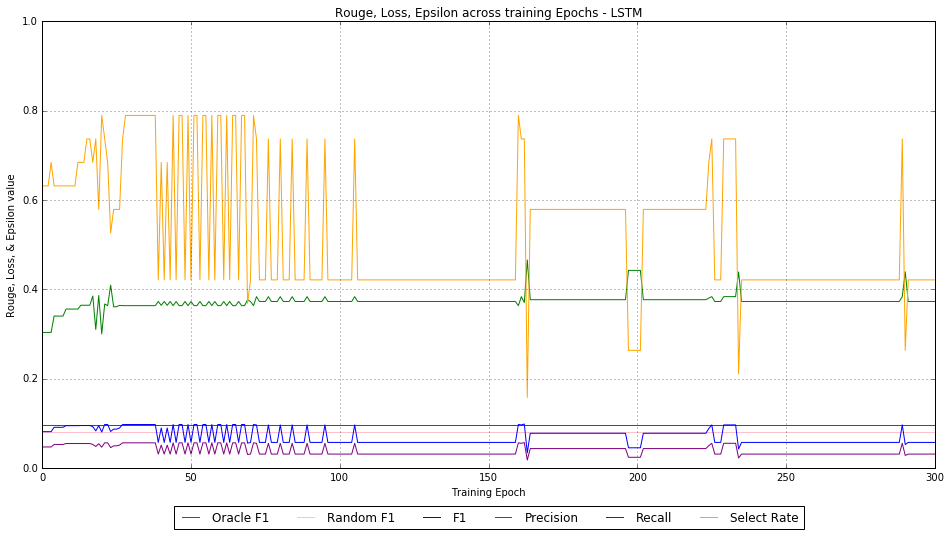

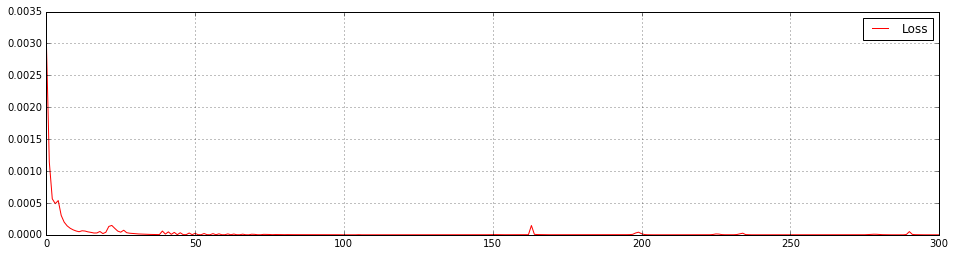

In [7]:
! time th runModel.lua --nepochs 300 --gamma 0. \
    --learning_rate 1e-4 --cuts 10 \
    --embeddingSize 50 --mem_size 300 --metric recall --n_samples 20 \
    --base_explore_rate 0.05 --model lstm --end_baserate 100

_ = plotdata('./Performance/lstm_recall_perf.txt', 'Rouge, Loss, Epsilon across training Epochs - LSTM')

## Learning F1 on 20 Records

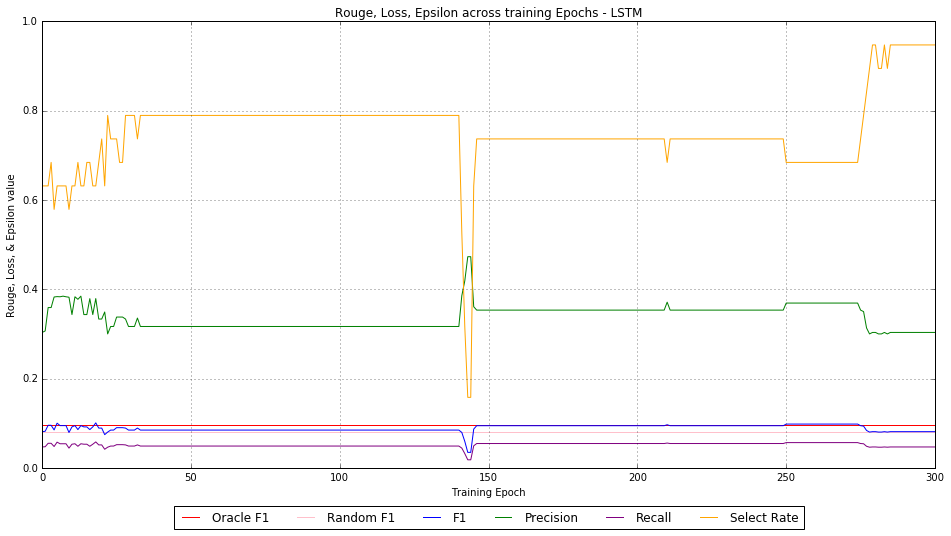

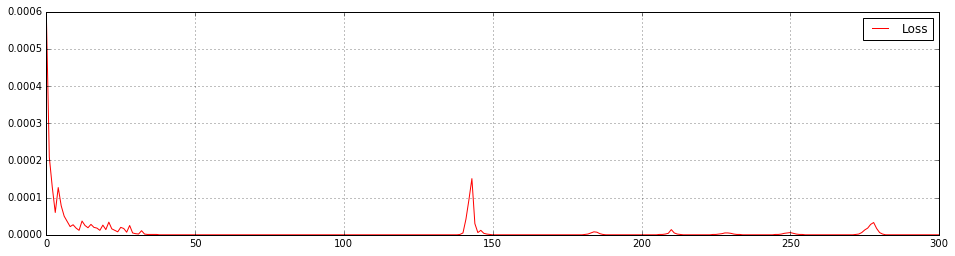

In [13]:
! time th runModel.lua --nepochs 300 --gamma 0. \
    --learning_rate 1e-4 --cuts 10 \
    --embeddingSize 50 --mem_size 300 --metric f1 --n_samples 20 \
    --base_explore_rate 0.05 --model lstm --end_baserate 100

_ = plotdata('./Performance/lstm_f1_perf.txt', 'Rouge, Loss, Epsilon across training Epochs - LSTM')

---------
# BOW model
---------

## Learning Precision on 20 Records

...Utils file loaded	
...running on CPU	
Running bag-of-words model to learn precision	
Model complete {Selected = 8; Skipped  = 11}; Final Rouge Recall, Precision, F1 = {0.044193;0.462366;0.080675}	

real	1m28.716s
user	1m24.194s
sys	0m3.713s


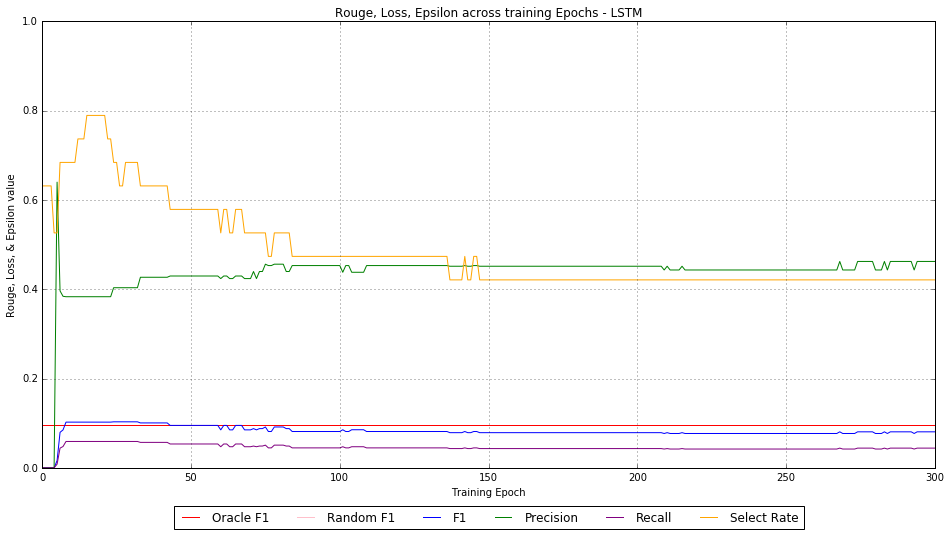

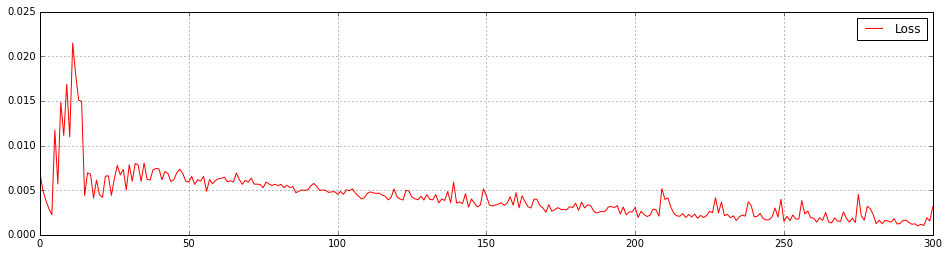

In [20]:
! time th runModel.lua --nepochs 300 --gamma 0. \
    --learning_rate 1e-4 --cuts 10 \
    --embeddingSize 50 --mem_size 300 --metric precision --n_samples 20 \
    --base_explore_rate 0.05 --model bow --end_baserate 100

_ = plotdata('./Performance/bow_precision_perf.txt', 'Rouge, Loss, Epsilon across training Epochs - LSTM')

## Learning Recall on 20 Records

...Utils file loaded	
...running on CPU	
Running bag-of-words model to learn false	
Model complete {Selected = 10; Skipped  = 9}; Final Rouge Recall, Precision, F1 = {0.036485;0.358586;0.066231}	

real	1m27.281s
user	1m22.950s
sys	0m3.477s


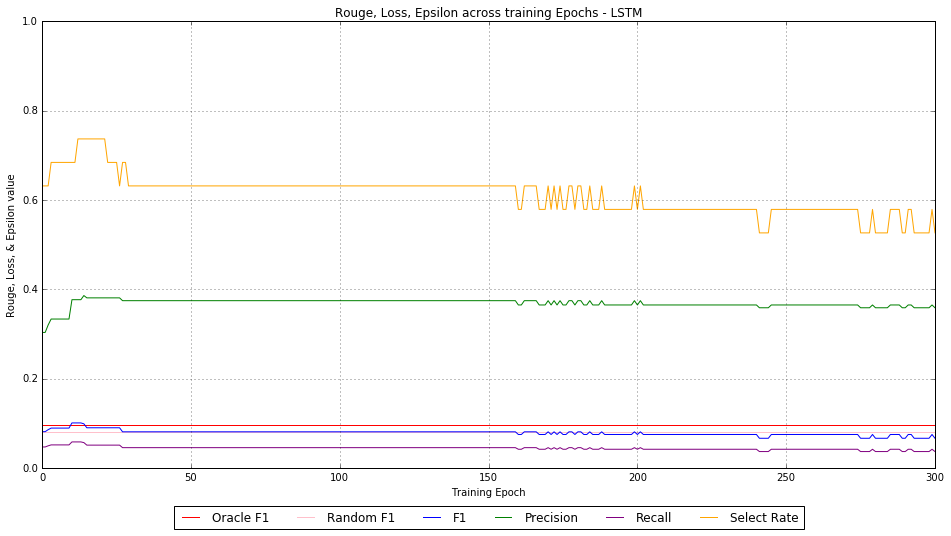

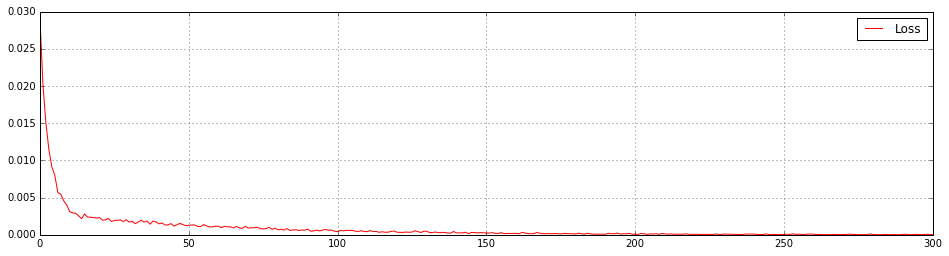

In [21]:
! time th testModel.lua --nepochs 300 --gamma 0. \
    --learning_rate 1e-4 --cuts 10 \
    --embeddingSize 50 --mem_size 300 --metric recall --n_samples 20 \
    --base_explore_rate 0.05 --model bow --end_baserate 100

_ = plotdata('./Performance/bow_recall_perf.txt', 'Rouge, Loss, Epsilon across training Epochs - LSTM')

## Learning F1 on 20 Records

...Utils file loaded	
...running on CPU	
Running bag-of-words model to learn false	
Model complete {Selected = 11; Skipped  = 8}; Final Rouge Recall, Precision, F1 = {0.043165;0.394366;0.077814}	

real	2m7.145s
user	2m2.563s
sys	0m3.810s


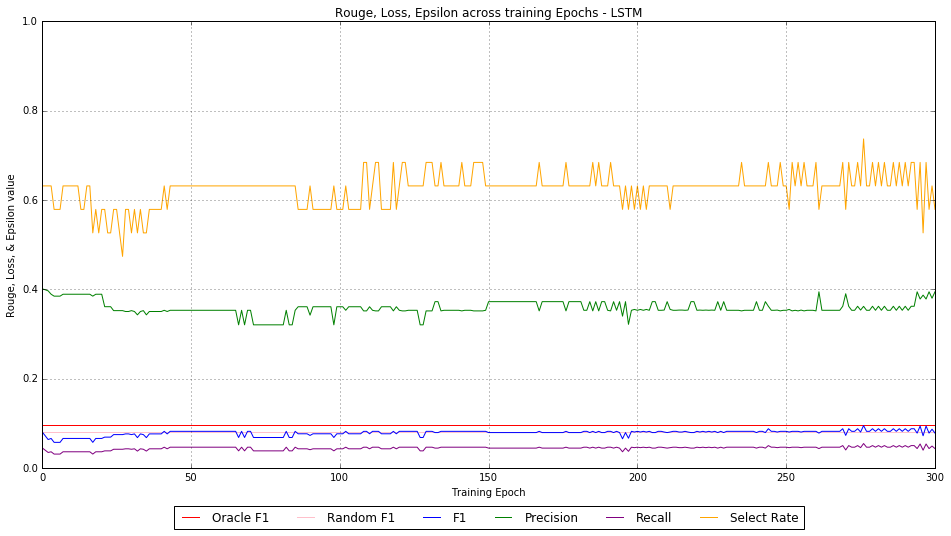

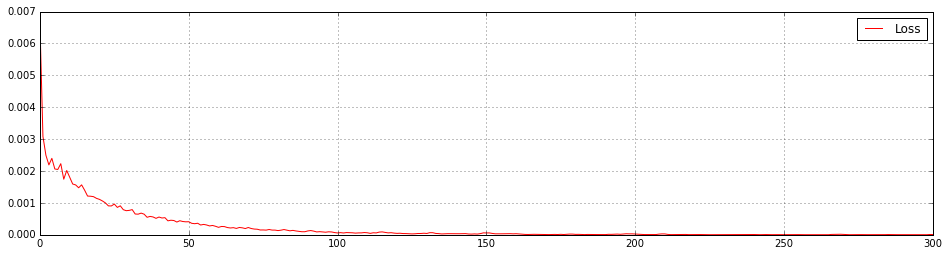

In [24]:
! time th runModel.lua --nepochs 300 --gamma 0. \
    --learning_rate 1e-4 --cuts 10 \
    --embeddingSize 50 --mem_size 300 --metric f1 --n_samples 20 \
    --base_explore_rate 0.05 --model bow --end_baserate 100

_ = plotdata('./Performance/bow_f1_perf.txt', 'Rouge, Loss, Epsilon across training Epochs - LSTM')

...Utils file loaded	
...running on CPU	
Running bag-of-words model to learn false	
Model complete {Selected = 15; Skipped  = 4}; Final Rouge Recall, Precision, F1 = {0.046763;0.303333;0.081033}	

real	1m27.849s
user	1m24.089s
sys	0m3.323s


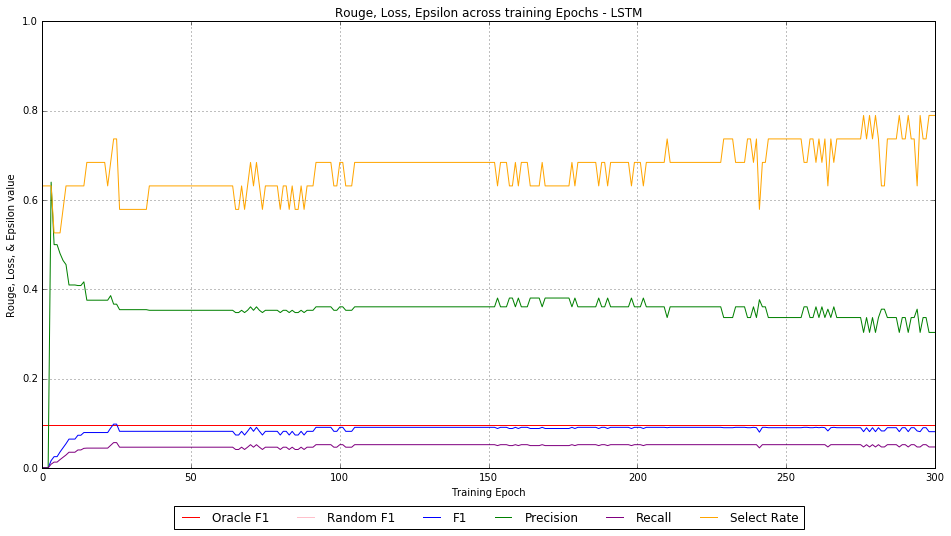

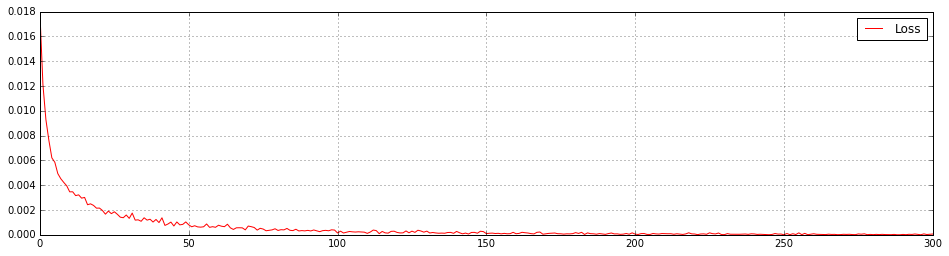

In [22]:
! time th testModel.lua --nepochs 300 --gamma 0. \
    --learning_rate 1e-4 --cuts 10 \
    --embeddingSize 50 --mem_size 300 --metric f1 --n_samples 20 \
    --base_explore_rate 0.05 --model bow --end_baserate 100

_ = plotdata('./Performance/bow_f1_perf.txt', 'Rouge, Loss, Epsilon across training Epochs - LSTM')

# Comparison of the models

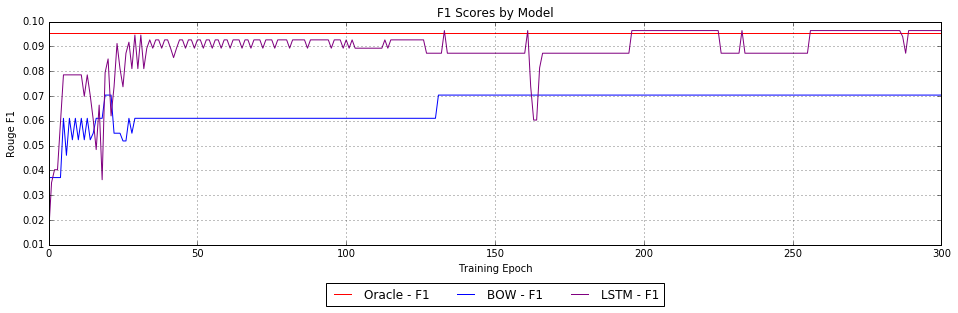

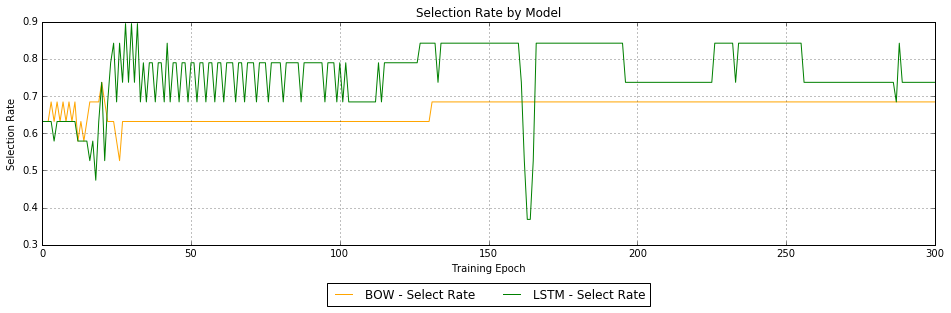

In [56]:
plotCompare('./bow_perf.txt', './lstm_perf.txt', 'F1 Scores by Model')

/Users/franciscojavierarceo/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


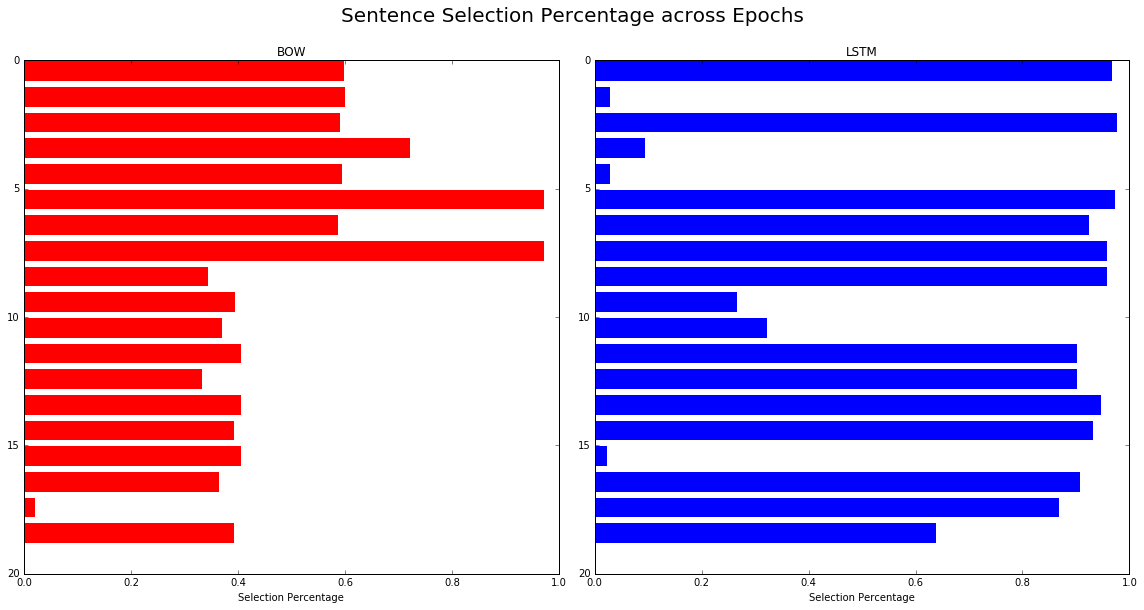

In [57]:
plotSelection('bow', 'lstm', 500)

# Running models on 200 sentences

...Utils file loaded	
...running on CPU	
Running LSTM model to learn f1	
Oracle - Greedy Search F1 = 0.175423 with 54 sentences selected	
Model complete {Selected = 87; Skipped  = 112}; Final Rouge Recall, Precision, F1 = {0.087359;0.566667;0.151380}	

real	319m22.584s
user	315m35.553s
sys	5m22.355s


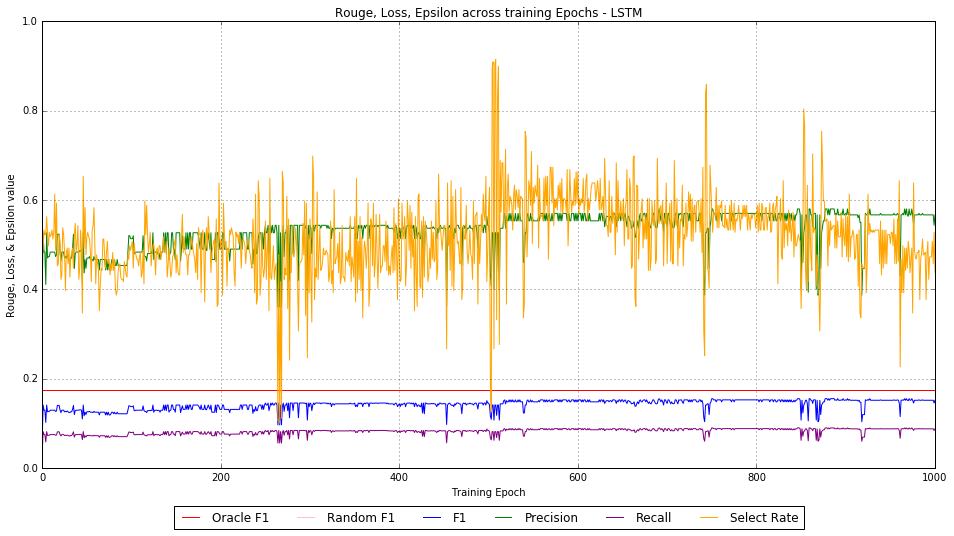

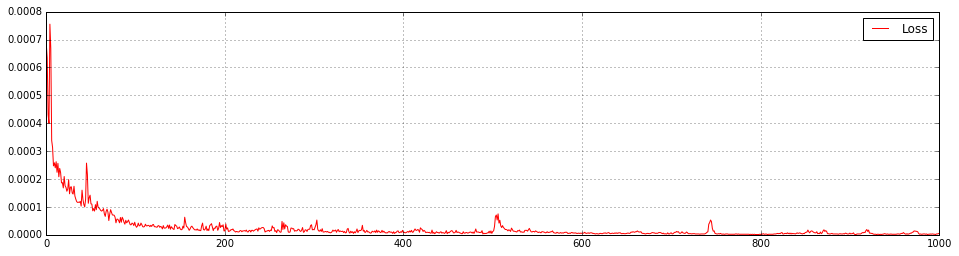

In [236]:
! time th testModel.lua --nepochs 1000 --gamma 0. \
    --learning_rate 1e-4 --cuts 10 \
    --edim 50 --mem_size 300 --metric f1 \
    --n_samples 200 --base_explore_rate 0.05 \
    --model lstm --end_baserate 500
    
_ = plotdata('./lstm_perf.txt', 'Rouge, Loss, Epsilon across training Epochs - LSTM')

In [ ]:
! time th testModel.lua --nepochs 1000 --gamma 0. \
    --learning_rate 1e-4 --cuts 10 \
    --embeddingSize 50 --mem_size 500 --metric f1 --n_samples 200 \
    --base_explore_rate 0.05 --model bow --end_baserate 200

_ = plotdata('./bow_perf.txt', 'Rouge, Loss, Epsilon across training Epochs - LSTM')

...Utils file loaded	
...running on CPU	
Running bag-of-words model to learn false	


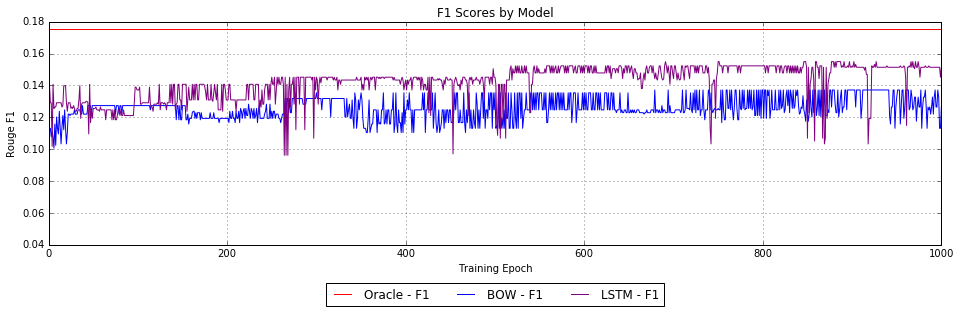

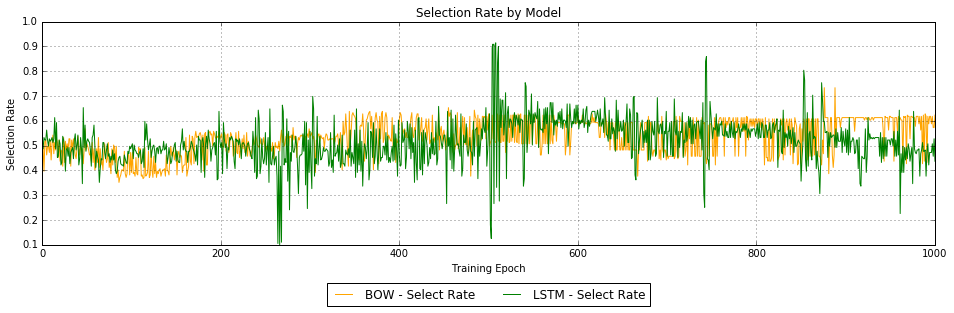

In [240]:
plotCompare('./bow_perf.txt', './lstm_perf.txt', 'F1 Scores by Model')

# Testing model on mutiple queries

In [2]:
! time th testModel.lua --nepochs 1000 --gamma 0. \
    --learning_rate 1e-4 --cuts 10 \
    --edim 50 --mem_size 400 --metric f1 --n_samples 20 \
    --base_explore_rate 0.10 --model bow --end_baserate 200

...Utils file loaded	
...running on CPU	
Running bag-of-words model to learn f1	
Model complete {Selected = 14; Skipped  = 5}; Final Rouge Recall, Precision, F1 = {0.027313;0.501832;0.051806}	

real	14m33.703s
user	11m33.549s
sys	2m59.156s


In [6]:
sd = pd.read_csv('./bow_perf.txt', sep=';')

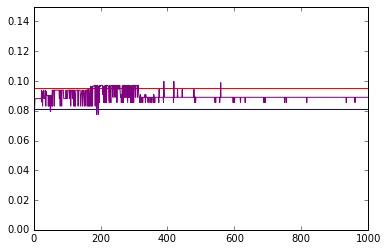

In [23]:
tmp = sd.ix[sd['query']==1, ['epoch','oracleF1' , 'randomF1','rougeF1']]
plt.plot(tmp['epoch'], tmp['oracleF1'], c='red',label='oracle')
plt.plot(tmp['epoch'], tmp['randomF1'], c='blue',label='random')
plt.plot(tmp['epoch'], tmp['rougeF1'], c='purple',label='bow')
plt.ylim([0,0.15])
plt.show()

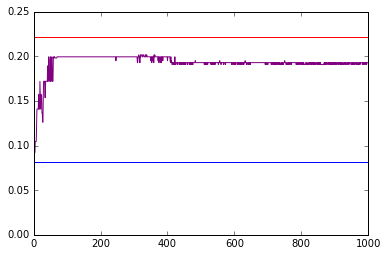

In [24]:
tmp = sd.ix[sd['query']==2, ['epoch','oracleF1' , 'randomF1','rougeF1']]
plt.plot(tmp['epoch'], tmp['oracleF1'], c='red',label='oracle')
plt.plot(tmp['epoch'], tmp['randomF1'], c='blue',label='random')
plt.plot(tmp['epoch'], tmp['rougeF1'], c='purple',label='bow')
plt.ylim([0,0.25])
plt.show()

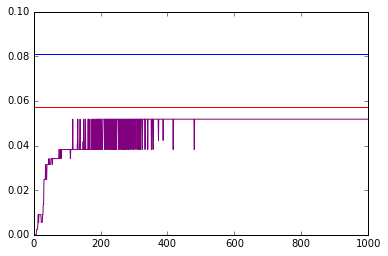

In [25]:
tmp = sd.ix[sd['query']==3, ['epoch','oracleF1' , 'randomF1','rougeF1']]
plt.plot(tmp['epoch'], tmp['oracleF1'], c='red',label='oracle')
plt.plot(tmp['epoch'], tmp['randomF1'], c='blue',label='random')
plt.plot(tmp['epoch'], tmp['rougeF1'], c='purple',label='bow')
plt.ylim([0,0.10])
plt.show()

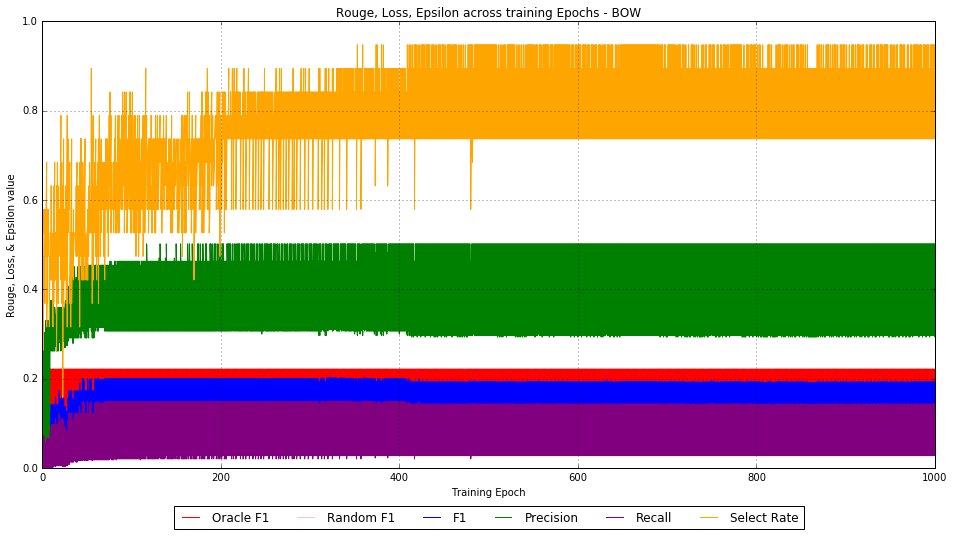

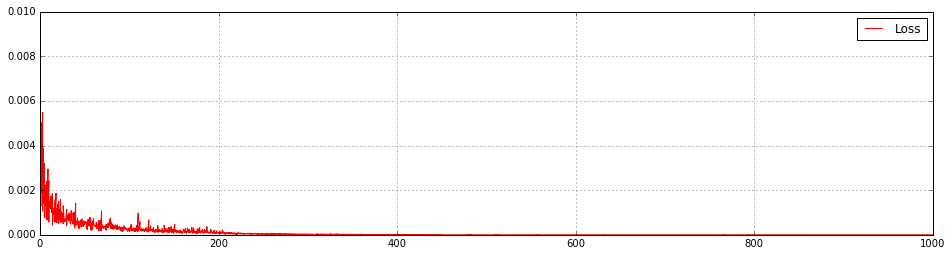

In [27]:
_ = plotdata('./bow_perf.txt', 'Rouge, Loss, Epsilon across training Epochs - BOW') 